# Imported Libraries

In [1]:
import math                         
import numpy as np                  
import pandas as pd               
import seaborn as sns              
import matplotlib.pyplot as plt   
%matplotlib inline                 
sns.set_theme(style = "darkgrid")
from sklearn.linear_model import LinearRegression
from scipy.stats import linregress
import statsmodels.api as sm
import quandl
import warnings
warnings.filterwarnings('ignore')
import datetime as dt


# Question 1

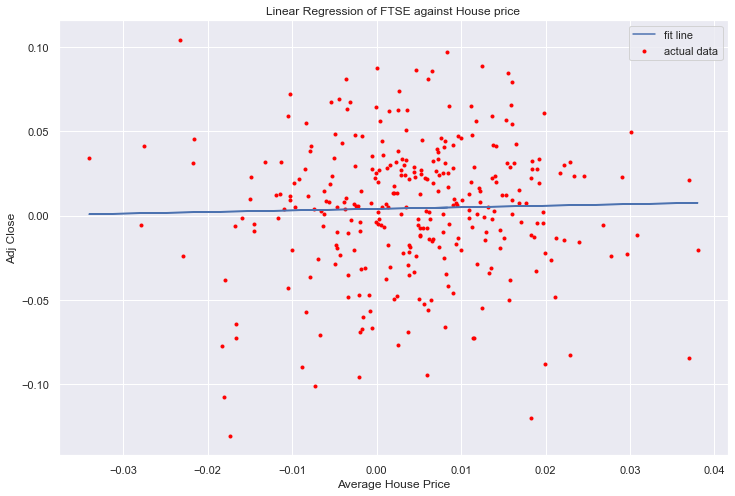

In [2]:
#Load House Price data into a data frame
housePriceDataFrame = pd.read_excel("monthlyhouseprice.xls")
housePriceDataFrame = housePriceDataFrame.rename(columns={"Unnamed: 0": 'Date'})
housePriceDataFrame = housePriceDataFrame[housePriceDataFrame['Date'] < '2017-01-01']
housePriceDataFrame = housePriceDataFrame[["Date", "Average House Price"]]
housePriceDataFrame = housePriceDataFrame.set_index("Date")
#Load FTSE Data into a dataframe
ftseDataframe = pd.read_csv("FTSE100.csv")
#converting the Date column to datetime data type
ftseDataframe['Date'] = pd.to_datetime(ftseDataframe['Date']).dt.to_period('M').dt.to_timestamp()
ftseDataframe = ftseDataframe[["Date", "Adj Close"]]
ftseDataframe = ftseDataframe.sort_values("Date")
ftseDataframe = ftseDataframe.set_index("Date")
#ftseDataframe

#Merge FTSE and House Price data
mergedDataFrame = pd.merge(housePriceDataFrame, ftseDataframe, on="Date")

#Calculate the percentage of returns
mergedDataFrame["House Returns"] = mergedDataFrame["Average House Price"].pct_change()
mergedDataFrame["FTSE Returns"] = mergedDataFrame["Adj Close"].pct_change()

#Compute Linear Regression where FTSE100 index is the dependent variable and House price as the independent variable
computeRegression = LinearRegression()
computeRegression.fit(mergedDataFrame["House Returns"][1:].values.reshape(-1,1), mergedDataFrame["FTSE Returns"][1:])

#Make a scatter plot the show the regression
plt.figure(figsize=(12, 8))
plt.title('Linear Regression of FTSE against House price')
plt.xlabel("Average House Price")
plt.ylabel('Adj Close')
mergedDataFrame.dropna(inplace=True)
xaxis = mergedDataFrame["House Returns"]
yaxis = mergedDataFrame["FTSE Returns"]
plt.scatter(xaxis, yaxis, color='red', marker='.', label='actual data')
a,b = np.polyfit(xaxis, yaxis, 1)
plt.plot(xaxis, a*xaxis + b, label='fit line')
plt.legend()
plt.show()



In [3]:
linregress(xaxis, yaxis)

LinregressResult(slope=0.09324142754349966, intercept=0.004047837686662456, rvalue=0.026551295701909915, pvalue=0.6409049000031651, stderr=0.1997058644355541, intercept_stderr=0.002437025309251721)

In [4]:
#Correlation Coefficient
print(f"The correlation coefficient is = {xaxis.corr(yaxis)}")


The correlation coefficient is = 0.026551295701909918


# Question 2a

In [5]:
#Load College Data Into a DataFrame
collegeDataFrame = pd.read_csv("College.csv")
collegeDataFrame = collegeDataFrame.rename(columns={"Unnamed: 0": 'University'})
collegeDataFrameNeededColumns = collegeDataFrame[[ "Apps", "Enroll", "Outstate", "Top10perc", "Top25perc"]]
collegeDataFrameNeededColumns.corr()


,Apps,Enroll,Outstate,Top10perc,Top25perc
Apps,1.000000,0.846822,0.050159,0.338834,0.351640
Enroll,0.846822,1.000000,-0.155477,0.181294,0.226745
Outstate,0.050159,-0.155477,1.000000,0.562331,0.489394
Top10perc,0.338834,0.181294,0.562331,1.000000,0.891995
Top25perc,0.351640,0.226745,0.489394,0.891995,1.000000


# Question 2b

In [6]:
#StepWise Regression Function
def forward_regression(X, y, threshold_in, verbose=False):
    initial_list = []
    included = list(initial_list)
    while True:
        changed=False
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            print(model.summary())
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        if not changed:
            break

    return included
print(forward_regression(collegeDataFrameNeededColumns, collegeDataFrame["Grad.Rate"], 0.05))

                            OLS Regression Results                            
Dep. Variable:              Grad.Rate   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.3870
Date:                Wed, 20 Oct 2021   Prob (F-statistic):              0.534
Time:                        21:53:02   Log-Likelihood:                -3311.3
No. Observations:                 777   AIC:                             6627.
Df Residuals:                     775   BIC:                             6636.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         65.7855      0.805     81.709      0.0

# Question 2c

In [7]:
#Computing the Bayesian Information Criterion
#add constant to predictor variables
yvalue = collegeDataFrame["Grad.Rate"]
x_predictor = sm.add_constant(collegeDataFrameNeededColumns)

#fit regression model
model = sm.OLS(yvalue, x_predictor).fit()

#view BIC of model
print(model.bic)

6283.746453405908


In [8]:
collegeDataFrameNeededColumns = collegeDataFrame[[ "Apps", "Enroll", "Outstate", "Top10perc"]]
yvalue = collegeDataFrame["Grad.Rate"]

x_predictor = sm.add_constant(collegeDataFrameNeededColumns)

#fit regression model
model = sm.OLS(yvalue, x_predictor).fit()

#view BIC of model
print(model.bic)

6288.068853071649


In [9]:
collegeDataFrameNeededColumns = collegeDataFrame[[ "Enroll", "Outstate", "Top10perc"]]
yvalue = collegeDataFrame["Grad.Rate"]

x_predictor = sm.add_constant(collegeDataFrameNeededColumns)

#fit regression model
model = sm.OLS(yvalue, x_predictor).fit()

#view BIC of model
print(model.bic)

6289.984325613547


In [10]:
collegeDataFrameNeededColumns = collegeDataFrame[["Outstate", "Top25perc"]]
yvalue = collegeDataFrame["Grad.Rate"]

x_predictor = sm.add_constant(collegeDataFrameNeededColumns)

#fit regression model
model = sm.OLS(yvalue, x_predictor).fit()

#view BIC of model
print(model.bic)

6274.3329824422635


# Question 2e

In [11]:
#Comparing the accuracy of the model
cmuData = collegeDataFrame[collegeDataFrame['University'] == 'Carnegie Mellon University']
collegeDataFrameNeededColumns = collegeDataFrame[[ "Apps", "Enroll", "Outstate", "Top10perc", "Top25perc"]]
cmuY = cmuData['Grad.Rate']
cmuDataBestFitColumns = cmuData[['Outstate', 'Top25perc']]
parameterY = collegeDataFrame['Grad.Rate']

xModelTwoVariables = collegeDataFrame[['Outstate', 'Top25perc']]
yModelOutputVariable = collegeDataFrame['Grad.Rate'] 

modelFiveVariables = LinearRegression().fit(collegeDataFrameNeededColumns, parameterY)

modelTwoVariables = LinearRegression().fit(xModelTwoVariables, yModelOutputVariable)

twoVariableScore = modelTwoVariables.score(xModelTwoVariables, yModelOutputVariable)
fiveVariableScore = modelFiveVariables.score(collegeDataFrameNeededColumns, parameterY)

print(f'Accuracy of model with useful predictors = {twoVariableScore}')
print(f'Accuracy of model with using all five predictors = {fiveVariableScore}')

Accuracy of model with useful predictors = 0.3777644174986873
Accuracy of model with using all five predictors = 0.3861582005130556


# Question 2f

In [12]:
cmuData = collegeDataFrame[collegeDataFrame['University'] == 'Carnegie Mellon University']
cmuDataBestFitColumns = cmuData[["Apps", "Enroll", "Outstate", "Top10perc", "Top25perc"]]

xVariable = collegeDataFrame[["Apps", "Enroll", "Outstate", "Top10perc", "Top25perc"]]
yVariable = collegeDataFrame['Grad.Rate']

model = LinearRegression().fit(xVariable, yVariable)

modelOfTwoVariable = model.score(xVariable, yVariable)

predictedGrad = model.predict(cmuDataBestFitColumns)[0]

print(f"The graduation rate value the accurate model should predict = {predictedGrad}")


The graduation rate value the accurate model should predict = 89.20112305346854


# Question 3

The correlation between GDP PER CAPITAL  and Air Passenger Carried is = 0.9371522324575831
The predicted value for situation in 2021 = 139433891.537364 


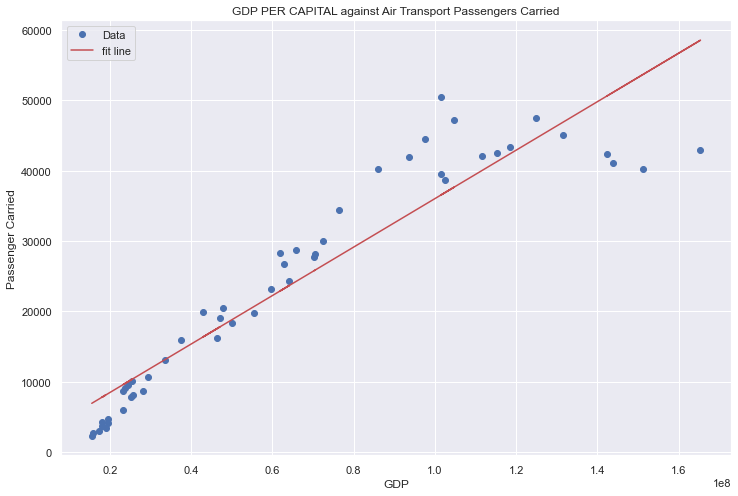

In [13]:
#Read in the air transport data and gdp data
airtransportDataFrame = pd.read_csv("airtransportPassenger.csv", header=4)
airtransportDataFrameUK = airtransportDataFrame[airtransportDataFrame['Country Name']=='United Kingdom']
#airtransportDataFrameNew = airtransportDataFrameUK.drop(['Country Name','Country Code', 'Indicator Name', 'Indicator Code'], axis=1)
gdpDataFrame = pd.read_csv("GDP_PER_CAPITAL.csv", header=4)
gdpDataFrameUK = gdpDataFrame[gdpDataFrame['Country Name']=='United Kingdom']
#gdpDataFrameNew = gdpDataFrameUK.drop(['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code'], axis=1)

mergedDataFrame = gdpDataFrameUK.append(airtransportDataFrameUK, ignore_index=True)

sliceData = mergedDataFrame.iloc[:, 4:].T
#Reset Index
sliceDataResetIndex = sliceData.reset_index()
#Rename columns
sliceDataResetIndex.columns = ['year', 'GDP', 'Passengers_Carried']

changeIndex = sliceDataResetIndex.dropna()

cleanDataFrame = changeIndex.reset_index(drop=True)

#Choosing GDP as the dependent variable and passengers as the independent
yVariable = cleanDataFrame['GDP']
xVariable = cleanDataFrame['Passengers_Carried']

computeLinRegress = linregress(xVariable, yVariable)

correlationCoff = xVariable.corr(yVariable)

print(f"The correlation between GDP PER CAPITAL  and Air Passenger Carried is = {correlationCoff}")

# To predict the situation in 2021
# To predict the number of air passengers carried in 2021
#Assume that the independent variable is the date -x
# And that the dependent variable is the number of passengers -y
predictData = cleanDataFrame.copy().dropna()
predictData['year'] = pd.to_datetime(predictData['year'])

#predict_data['year'] = predict_data['year'].apply(lambda v: v.toordinal())

predictData['year'] = predictData['year'].map(dt.datetime.toordinal)

xaxis = np.array(predictData['year']).reshape(-1, 1) 
yaxis = np.array(predictData['Passengers_Carried']).reshape(-1, 1) 

model = LinearRegression().fit(xaxis, yaxis)

dataframe = {'year': '2021'}

dataframe1 = predictData.append(dataframe, ignore_index = True)
dataframe2 = dataframe1.reset_index()
value2021 = dataframe2[dataframe2['year'] == '2021']
value2021['year'] = pd.to_datetime(value2021['year'])
value2021['year'] = value2021['year'].map(dt.datetime.toordinal)

x1 = np.array(value2021['year']).reshape(-1, 1) 

predictedValue = model.predict(x1)[0][0]
print(f"The predicted value for situation in 2021 = {predictedValue} ")
plt.figure(figsize=(12,8))
plt.title('GDP PER CAPITAL against Air Transport Passengers Carried')
plt.xlabel("GDP")
plt.ylabel('Passenger Carried')
plt.plot(xVariable, yVariable, 'o', label='Data')
plt.plot(xVariable, computeLinRegress.intercept + computeLinRegress.slope*xVariable, 'r', label='fit line')
plt.legend()
plt.show()


# Question 4

In [14]:
quandl.ApiConfig.api_key = '5i_x3_cfD-xJtePStTBW'
quandl.ApiConfig.verify_ssl = False

unemploymentDataFrame = quandl.get('ODA/ISR_LUR')
unemploymentDataFrame = unemploymentDataFrame.reset_index()
neededDateData = unemploymentDataFrame.iloc[:-11:, :]
#unemploymentDataFrame
neededDateData['Date'] = neededDateData['Date'].map(dt.datetime.toordinal)
#neededDateDataConverted
xaxis = np.array(neededDateData["Date"]).reshape(-1, 1)
yaxis = np.array(neededDateData["Value"]).reshape(-1, 1)
modelGet = LinearRegression().fit(xaxis, yaxis)

neededDateData_2020 = unemploymentDataFrame[unemploymentDataFrame['Date'] == '2020-12-31']
neededDateData_2020 = neededDateData_2020.reset_index()
neededDateData_2020['Date'] =  neededDateData_2020['Date'].map(dt.datetime.toordinal)
xaxis2020 = np.array(neededDateData_2020['Date']).reshape(-1, 1)

predictModelValue = modelGet.predict(xaxis2020)[0][0]

def MAPE(actualValue, predictModelValue):
    myMape = np.mean(np.abs((actualValue - predictModelValue)/actualValue))*100
    return myMape
getAccuracy = MAPE(12, predictModelValue)
print(f"The Predicted value of the model is {predictModelValue}%")
print(f"The accuracy of the model is {getAccuracy}%")

The Predicted value of the model is 11.361275642432076%
The accuracy of the model is 5.322702979732696%
